# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
old_store = paths.AnalysisStorage("mstis.nc")

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

In [5]:
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
rate = network.rate_matrix(old_store.steps)

One of the points of SRTIS is that we use a bias (which comes from an estimate of the crossing probability) in order to improve our sampling.

In [6]:
# this is the normal way you'd get this table
table = {}
for t in network.sampling_transitions:
    for ens, lambda_ens in zip(t.ensembles, [0.04, 0.09, 0.15]):
        table[ens] = t.tcp(lambda_ens)
for ens in network.special_ensembles['ms_outer'].keys():
    table[ens] = 0.0
    for t in network.sampling_transitions:
        table[ens] += t.tcp(0.25)
    table[ens] *= len(network.special_ensembles['ms_outer'].keys())
    # TODO: Justify the math behind that. Also, run it a bunch more times.
    
# However, we usually have a short (bad statistics) run in "mstis.nc"
# Here are results that I got from a 10k MC step run
desired_table = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.13631671445062318,
    "Out A 2" : 0.024940771341558789,
    "Out B 0" : 1.0,
    "Out B 1" : 0.17104343305339545,
    "Out B 2" : 0.03927673242602249,
    "Out C 0" : 1.0,
    "Out C 1" : 0.19353622940592666,
    "Out C 2" : 0.066440692846493191,
    "[UnionEnsemble]" : (0.0030508557603910859+0.0087422825961122538+0.017858280680711457)*3
} # Union is sum of outermost vals for all 3 versions, times the number of versions

# now we'll set `table` based on `desired_table`
table = {}
my_ensembles = network.sampling_ensembles + network.special_ensembles['ms_outer'].keys()
for ens in my_ensembles:
    table[ens] = desired_table[ens.name]

In [7]:
bias = paths.BiasEnsembleTable(table)

Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [8]:
scheme = paths.SRTISScheme(network, bias=bias, engine=engine)

Now we'll visualize the SRTIS move scheme.

In [9]:
movevis = paths.visualize.MoveTreeBuilder()
#movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
#SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [10]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [11]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [12]:
storage = paths.Storage("srtis.nc", "w", template)

In [13]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    move_scheme=scheme
)

In [14]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=2
    ))
print n_steps_to_run

2460


In [15]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [16]:
srtis.run_until(2*n_steps_to_run)

Working on Monte Carlo cycle number 4920.
DONE! Completed 4920 Monte Carlo cycles.


In [17]:
storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [18]:
storage = paths.AnalysisStorage("srtis.nc")
scheme = storage.schemes[0]

In [19]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 8.046% (expected 0.41%) of the cycles with acceptance 32/42 (76.19%)
repex ran 46.743% (expected 3.66%) of the cycles with acceptance 81/244 (33.20%)
shooting ran 26.628% (expected 3.66%) of the cycles with acceptance 85/139 (61.15%)
minus ran 0.000% (expected 0.24%) of the cycles with acceptance 0/0 (nan%)
pathreversal ran 18.582% (expected 2.03%) of the cycles with acceptance 57/97 (58.76%)


In [20]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out C 1 ran 1.916% (expected 0.41%) of the cycles with acceptance 7/10 (70.00%)
OneWayShootingMover Out B 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 2 ran 2.682% (expected 0.41%) of the cycles with acceptance 6/14 (42.86%)
OneWayShootingMover Out B 1 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out A 2 ran 9.387% (expected 0.41%) of the cycles with acceptance 30/49 (61.22%)
OneWayShootingMover Out A 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 2 ran 12.644% (expected 0.41%) of the cycles with acceptance 42/66 (63.64%)
OneWayShootingMover Out A 1 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)


In [21]:
scheme.move_summary(storage.steps, 'minus')

SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)


In [22]:
scheme.move_summary(storage.steps, 'repex')

EnsembleHop Out A 1->Out A 2 ran 0.575% (expected 0.20%) of the cycles with acceptance 3/3 (100.00%)
EnsembleHop [UnionEnsemble]->Out A 2 ran 4.215% (expected 0.20%) of the cycles with acceptance 8/22 (36.36%)
EnsembleHop [UnionEnsemble]->Out B 2 ran 5.556% (expected 0.20%) of the cycles with acceptance 3/29 (10.34%)
EnsembleHop Out B 1->Out B 0 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 0->Out C 1 ran 0.192% (expected 0.20%) of the cycles with acceptance 1/1 (100.00%)
EnsembleHop Out C 1->Out C 0 ran 0.766% (expected 0.20%) of the cycles with acceptance 1/4 (25.00%)
EnsembleHop Out C 2->[UnionEnsemble] ran 6.513% (expected 0.20%) of the cycles with acceptance 13/34 (38.24%)
EnsembleHop Out B 2->Out B 1 ran 1.916% (expected 0.20%) of the cycles with acceptance 2/10 (20.00%)
EnsembleHop Out C 2->Out C 1 ran 5.747% (expected 0.20%) of the cycles with acceptance 10/30 (33.33%)
EnsembleHop Out C 1->Out C 2 ran 1.916% (expected 0.20%) of the cycle

In [23]:
replica = storage.samplesets[0].samples[0].replica
print len(paths.trace_ensembles_for_replica(replica, storage.steps))

4921


In [24]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out C 0
1 : Out C 1
2 : Out C 2
3 : Out A 0
4 : Out A 1
5 : Out A 2
6 : Out B 0
7 : Out B 1
8 : Out B 2
9 : [UnionEnsemble]


In [25]:
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage.steps)

In [26]:
hist_numbers = [srtis_ensembles.index(e) for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

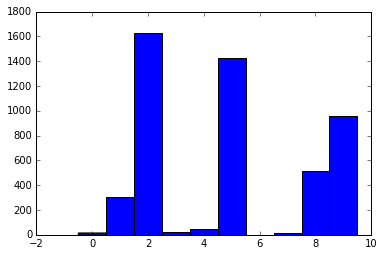

In [27]:
plt.hist(hist_numbers, bins=bins);

In [28]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = {i : srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))}
df = pd.DataFrame(columns=[colnames[i] for i in colnames])

In [29]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        normalized = hist.normalized()
        local_df = pd.DataFrame([normalized.values()], index=[i], columns=[colnames[k] for k in normalized.keys()])
        df = df.append(local_df)

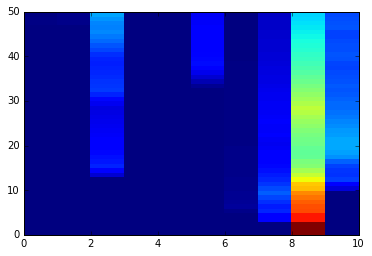

In [30]:
plt.pcolormesh(df.fillna(0.0));